In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature as cfeature

In [3]:
met_df = pd.read_pickle('metar_20190801_df.pkl') # Training
met_df_test = pd.read_pickle('metar_20200801_df.pkl') # Testing

In [4]:
hrrr_df_train = pd.read_pickle('hrrr_20190801_df.pkl')
hrrr_df_test = pd.read_pickle('hrrr_20200501_df.pkl')

In [5]:
hrrr_df_train

,WindGust,Longitude,Latitude,Temperature,WindU,WindV,PrecipRate
0,6.42368,-122.719528,21.138123,297.571167,-5.548723,-3.178455,0.0
1,6.36118,-122.692861,21.145110,297.571167,-5.486223,-3.240955,0.0
2,6.36118,-122.666190,21.152090,297.571167,-5.361223,-3.303455,0.0
3,6.29868,-122.639515,21.159063,297.571167,-5.298723,-3.303455,0.0
4,6.23618,-122.612835,21.166029,297.508667,-5.236223,-3.365955,0.0
...,...,...,...,...,...,...,...
1905136,4.11118,-61.063480,47.883306,289.758667,-0.673723,1.446545,0.0
1905137,4.23618,-61.026890,47.873043,289.758667,-0.798723,1.571545,0.0
1905138,4.42368,-60.990312,47.862771,289.696167,-0.923723,1.634045,0.0
1905139,4.48618,-60.953746,47.852488,289.633667,-1.048723,1.821545,0.0


In [6]:
array_train = hrrr_df_train.values
X_train = array_train[:, 1:6]
y = array_train[:, 0]

scaler = StandardScaler()
rescaled_X_train = (scaler.fit_transform(X_train[:, 3:6])) # doesn't include lon, lat

array_test = hrrr_df_test.values
X_test = array_test[:, 1:6]
truth = array_test[:, 0]

rescaled_X_test = (scaler.fit_transform(X_test[:, 3:6])) # doesn't include lon, lat

### Training the neural net
Puts strain on the computer, is there a better way? 

In [7]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                   alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                   power_t=0.5, max_iter=1500, shuffle=True, random_state=None, tol=0.0001, verbose=False,
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                   validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
mlp = mlp.fit(rescaled_X_train, y)

/Applications/anaconda3/envs/wind_gust/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### Run neural net

In [9]:
y_predict_mlp = mlp.predict(rescaled_X_test)

### Plot neural net

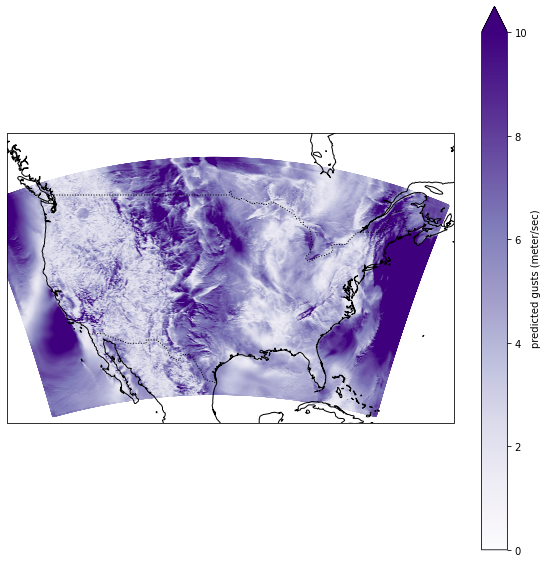

In [10]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict_mlp, cmap='Purples',
          vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='predicted gusts (meter/sec)', extend='max')
plt.show()

### Plot truth

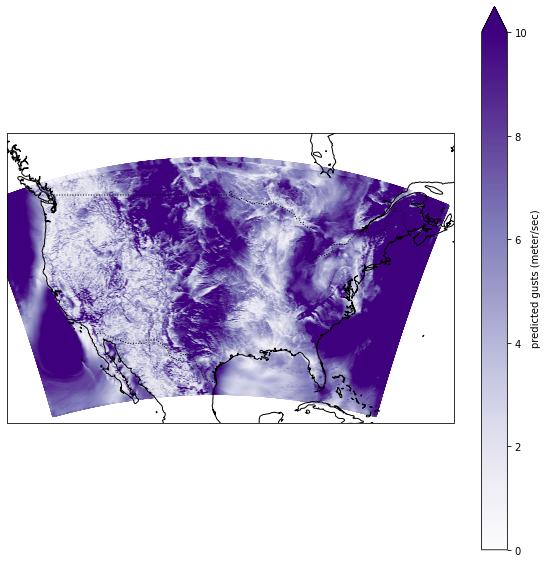

In [11]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(X_test[:, 0], X_test[:, 1], c=truth, cmap='Purples',
          vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='predicted gusts (meter/sec)', extend='max')
plt.show()

### Plot training day

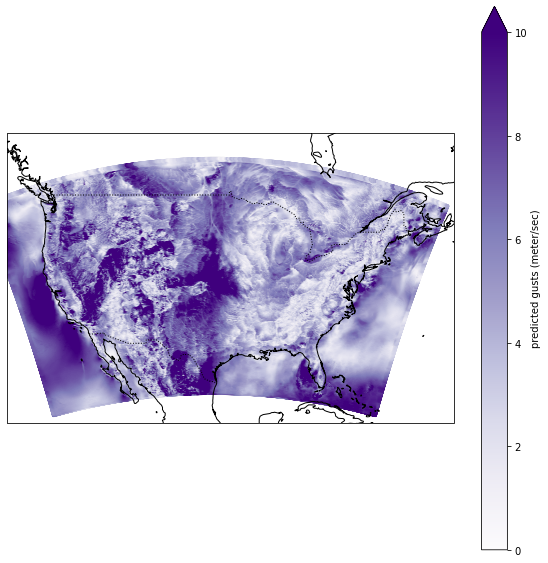

In [12]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(X_train[:, 0], X_train[:, 1], c=y, cmap='Purples',
          vmin=0, vmax=10, s=5, transform=ccrs.PlateCarree())

plt.colorbar(label='predicted gusts (meter/sec)', extend='max')
plt.show()